# Preprocess Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv("resources/stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Drop 'id' column

In [5]:
df = df.drop(['id'], axis=1)

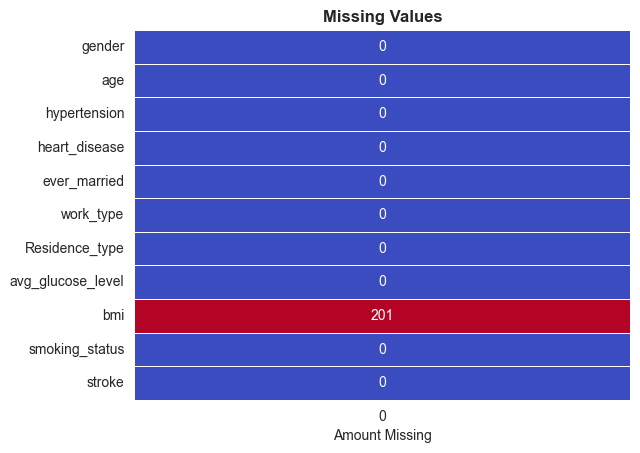

In [6]:
plt.title('Missing Values',fontweight='bold')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='coolwarm', linewidths=0.5,cbar=False)
ax.set_xlabel('Amount Missing')
plt.show()

### Fill missing values

In [7]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

Text(0.5, 1.0, 'Stroke')

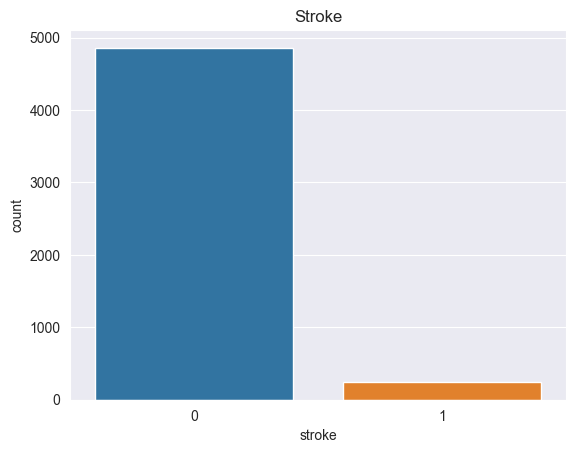

In [8]:
sns.countplot(data=df, x="stroke")
plt.title('Stroke')

# Look at the Data

In [9]:
round (df.describe(exclude = 'object'), 2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,5110.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.70,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.80,0.00
50%,45.00,0.0,0.00,91.88,28.40,0.00
75%,61.00,0.0,0.00,114.09,32.80,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


In [10]:
round (df.describe(exclude = ['float', 'int64']),2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


# Numeric Variable Distribution

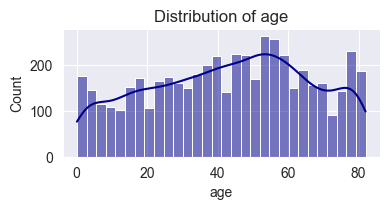

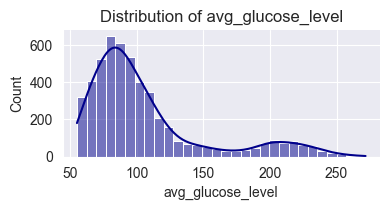

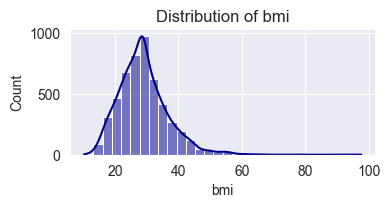

In [11]:

for col in df[['age','avg_glucose_level', 'bmi' ]].columns:
    sns.displot(df[col], bins=30, kde=True, color='darkblue', height=2, aspect=2).set(xlabel=col,title=f'Distribution of {col}')

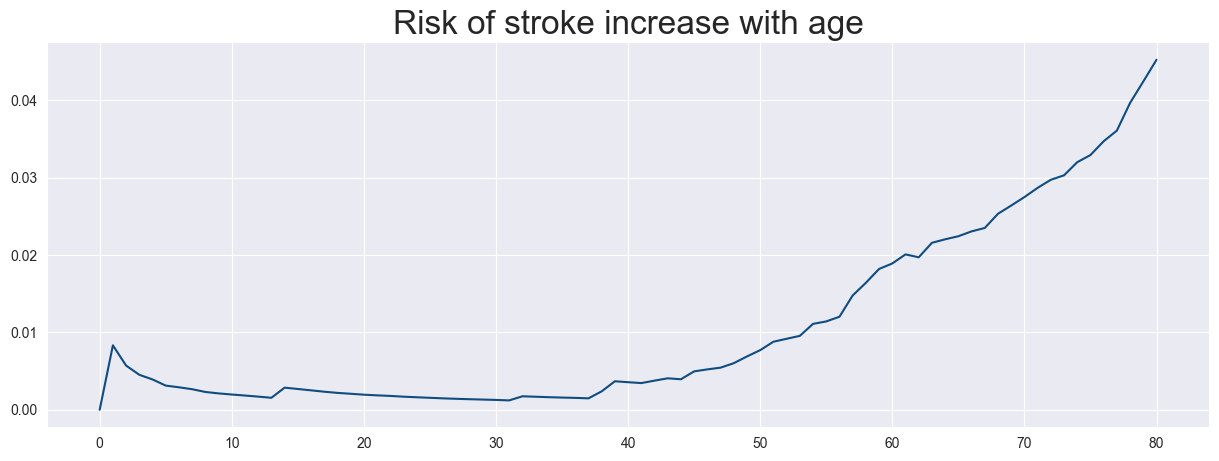

In [12]:
rate = []
ages = df['age'].astype(int)
for i in range(ages.min() + 1, ages.max()):
    rate.append((df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke'])))
    
fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(data=rate,color='#0f4c81', ax = ax).set_title("Risk of stroke increase with age",fontsize=24)
plt.show()

# Model preparation

In [13]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(df, labels, encoder):
    for label in labels:
        df[label] = encoder.fit_transform(df[label])


labels_to_encode = ['gender', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']
encode_labels(df,labels_to_encode, LabelEncoder())

In [14]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,28.893237,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.000000,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.600000,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.600000,1,0


# Correlations 

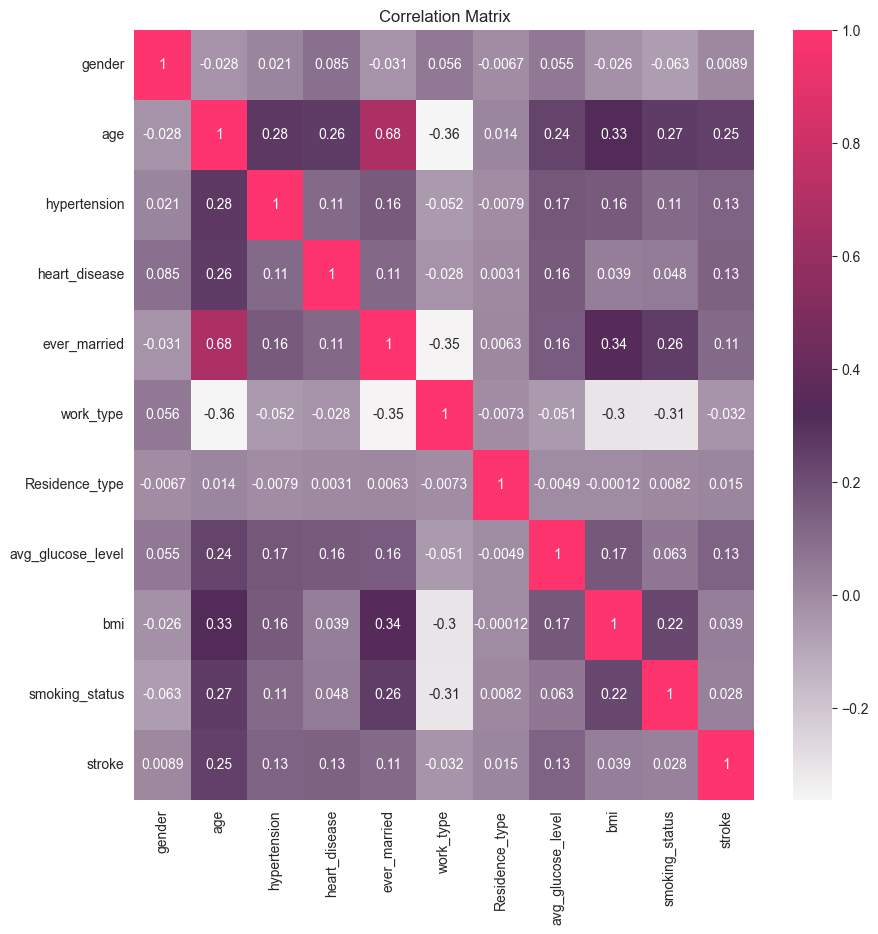

In [15]:
colors = ['#f6f5f5','#512b58','#fe346e']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True,cmap= colormap, facecolor='#f6f5f5', ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

## Split dataset

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop(['stroke'], axis=1)
y = df['stroke']

## Balance dataset

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [18]:
oversampler = SMOTE(sampling_strategy = 1)

# X, y = oversampler.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_init = X_train
y_train_init = y_train

X_train, y_train = oversampler.fit_resample(X_train, y_train)

<Axes: xlabel='stroke', ylabel='count'>

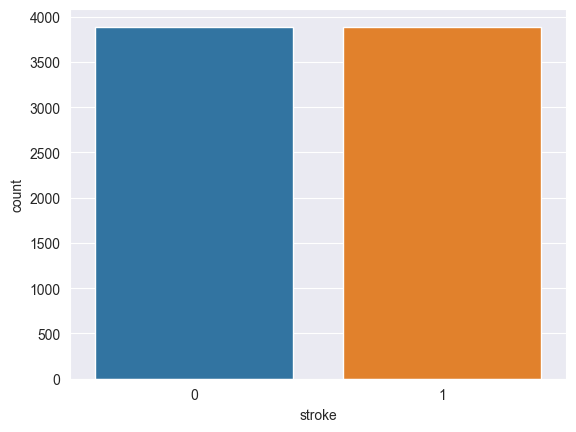

In [19]:
sns.countplot(x=y_train)

# Building models

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [21]:
def display_confution_matrix(name, y_test, y_predicted ):
    plt.title(name)
    sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, fmt='g', cmap='coolwarm', cbar=False,
        yticklabels=['Actual non-stroke', 'Actual Stroke'], xticklabels=['Predicted non-stroke', 'Predicted stroke'])
    plt.show()
    
def display_ROC_curve(name, model, X_test, y_test):
    curr_model_pred_p = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, curr_model_pred_p)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC ({name}) = ' + str(round(roc_auc, 2)))
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC curve plot ({name})')
    plt.show()

In [22]:
def test_models(X_train, y_train, X_test, y_test, models):
    model_scores = []
    for name, model in models:

        curr_model = model
        curr_model.fit(X_train, y_train)
        curr_model_pred = curr_model.predict(X_test)
        cm_model = confusion_matrix(y_test, curr_model_pred)
        model_scores.append((name, accuracy_score(y_test, curr_model_pred), f1_score(y_test, curr_model_pred)))

        display_confution_matrix(name, y_test, curr_model_pred)

        display_ROC_curve(name, curr_model, X_test, y_test)
        
        print(classification_report(y_test, curr_model_pred))

    return model_scores

In [23]:
models = [
        ['KNearest Neighbor Classifier',KNeighborsClassifier(leaf_size=1, n_neighbors=14, p=2)],
        ['Decision Tree Classifier ',DecisionTreeClassifier()],
        ['Ada Boost Classifier',AdaBoostClassifier()],
        ['SVM Classifier',SVC(probability=True)],
    ]

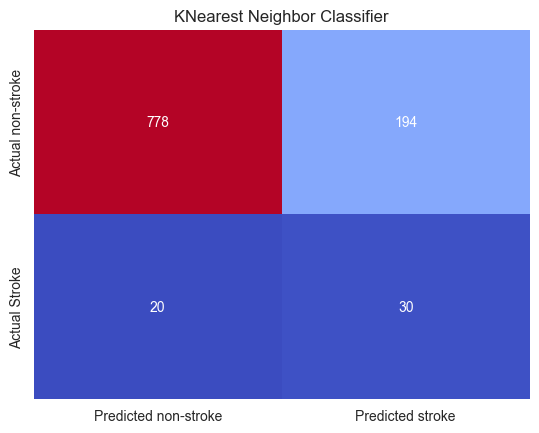

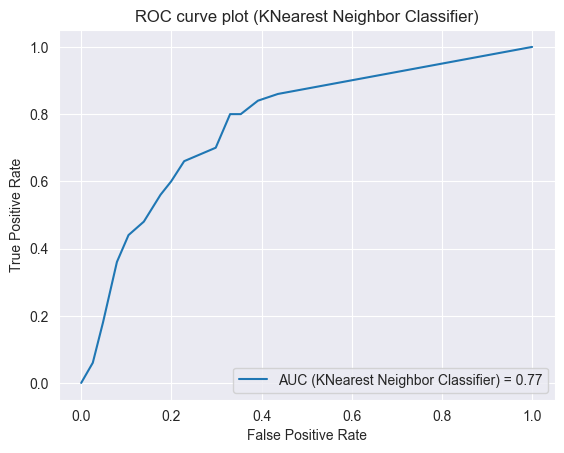

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.13      0.60      0.22        50

    accuracy                           0.79      1022
   macro avg       0.55      0.70      0.55      1022
weighted avg       0.93      0.79      0.85      1022



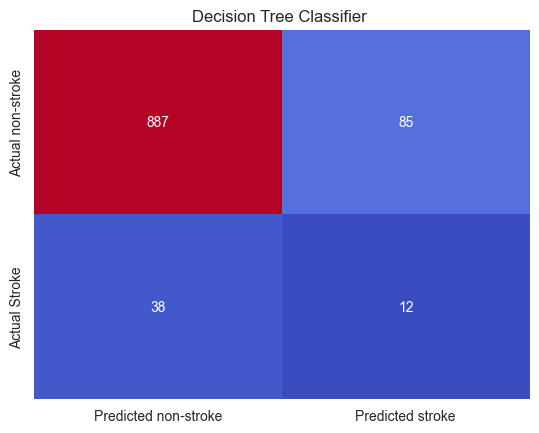

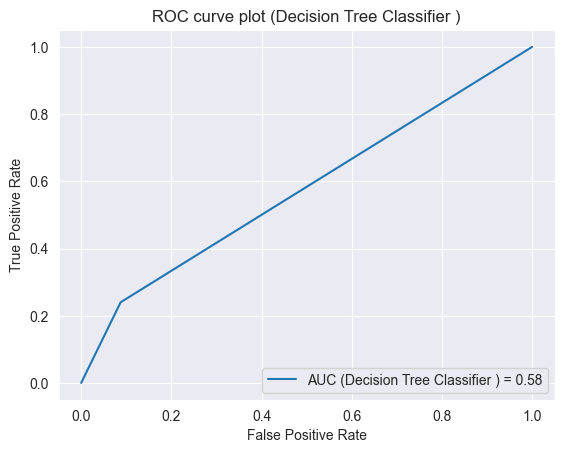

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       972
           1       0.12      0.24      0.16        50

    accuracy                           0.88      1022
   macro avg       0.54      0.58      0.55      1022
weighted avg       0.92      0.88      0.90      1022



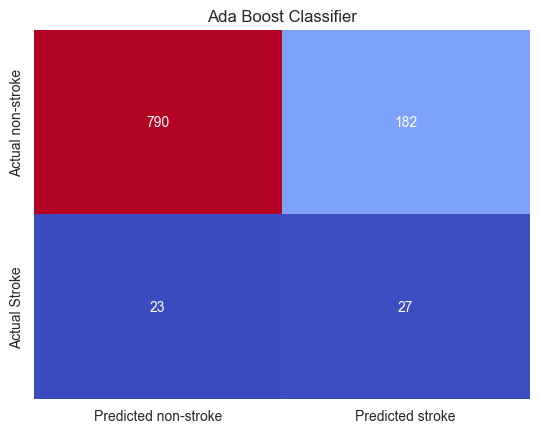

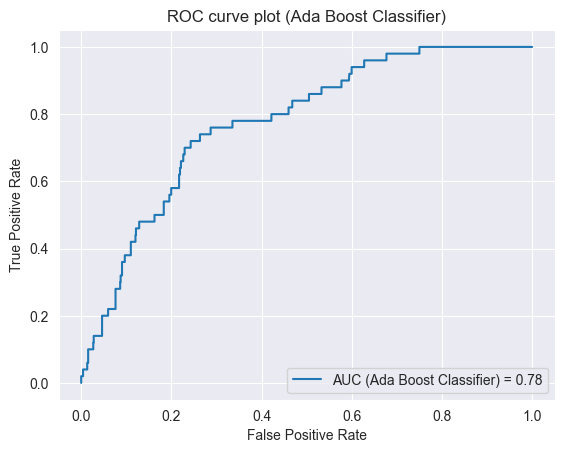

              precision    recall  f1-score   support

           0       0.97      0.81      0.89       972
           1       0.13      0.54      0.21        50

    accuracy                           0.80      1022
   macro avg       0.55      0.68      0.55      1022
weighted avg       0.93      0.80      0.85      1022



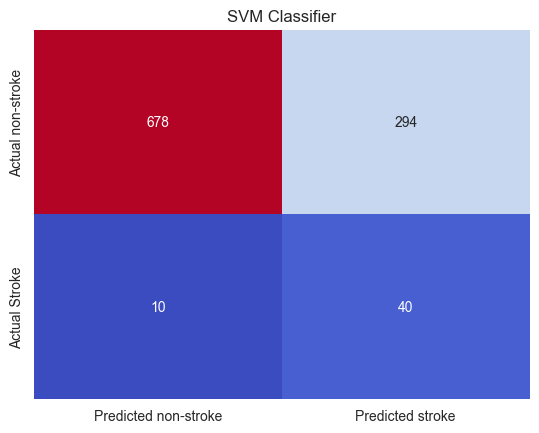

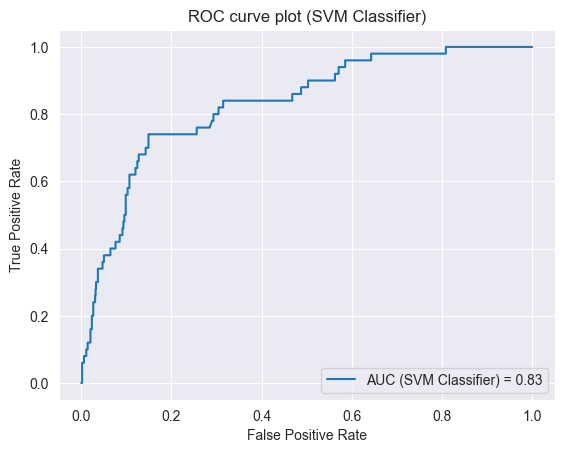

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.12      0.80      0.21        50

    accuracy                           0.70      1022
   macro avg       0.55      0.75      0.51      1022
weighted avg       0.94      0.70      0.79      1022



In [24]:
model_scores = test_models(X_train, y_train, X_test, y_test, models)

In [25]:
def cross_validate(X, y, models):
    for name, model in models:
        pipeline = Pipeline(steps = [['smote', SMOTE(random_state=11)],
#                                         ['scaler', MinMaxScaler()],
                                        ['classifier', model]])

        cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
        print(f'Model name: {name}')
        print("Cross Validation Score (recall): ",'{0:.2%}'.format(cross_val_score(pipeline, X, y, cv = cv, scoring = 'recall').mean()))



In [26]:
# cross_validate(X, y, models)

Model name: KNearest Neighbor Classifier
Cross Validation Score (recall):  63.57%
Model name: Decision Tree Classifier 
Cross Validation Score (recall):  26.23%
Model name: Ada Boost Classifier
Cross Validation Score (recall):  49.41%
Model name: SVM Classifier


KeyboardInterrupt: 

# Model Tuning

In [ ]:
def tune_model(model, params, X_train, y_train):
    cv =  RepeatedStratifiedKFold(n_splits = 2, n_repeats = 3, random_state = 42)
    
    pipeline = Pipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', model]])
    
    grid = GridSearchCV(pipeline, param_grid=params, scoring='recall', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    

In [ ]:
knn_params = [{'classifier__n_neighbors': [3, 5, 7, 9, 10, 15],
         'classifier__weights': ['uniform', 'distance'],
         'classifier__leaf_size': [15, 20]}]

tune_model(KNeighborsClassifier(),knn_params, X_train_init, y_train_init)

In [ ]:
# model = KNeighborsClassifier(leaf_size = 15, n_neighbors = 3, weights = 'distance')
model = KNeighborsClassifier(leaf_size = 15, n_neighbors = 15, weights = 'uniform')

test_models(X_train, y_train, X_test, y_test, [['KNN', model]])